# Importing necessary Libraries

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from datetime import datetime
from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
%matplotlib inline
!pip install pmdarima --quiet
import pmdarima as pm
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [26]:
data = pd.read_excel('/content/sea_temp.xlsx')
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format = True)
data = data.set_index(['Date'])
data.head()

,Year,Month,Sea Surface Temperature (Deg C)
Date,,,
1900-01-01,1900,1,26.32
1900-02-01,1900,2,26.45
1900-03-01,1900,3,27.57
1900-04-01,1900,4,29.15
1900-05-01,1900,5,29.76


In [27]:
data.shape

(1480, 3)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1480 entries, 1900-01-01 to 2023-04-01
Data columns (total 3 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Year                             1480 non-null   int64  
 1   Month                            1480 non-null   int64  
 2   Sea Surface Temperature (Deg C)  1480 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 46.2 KB


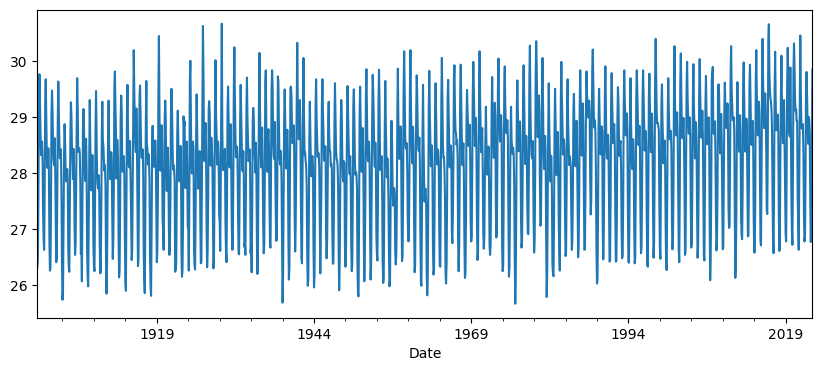

In [29]:
plt.figure(figsize = (10, 4))
data['Sea Surface Temperature (Deg C)'].plot();

# Checking the stationarity

In [65]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def check_stationarity(transformed_data, window_size=12, alpha=0.05):
    transformed_data.dropna(inplace = True)
    # Calculate moving statistics
    rolling_mean = transformed_data.rolling(window=window_size).mean()
    rolling_std = transformed_data.rolling(window=window_size).std()


    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(transformed_data, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    # Check the stationarity based on the p-value
    if dftest[1] < alpha:
        print('Reject the null hypothesis. The data is stationary.')
        print('------------------------------------------------------------')
        # return True
    else:
        print('Fail to reject the null hypothesis. The data is non-stationary.')
        print('-------------------------------------------------------------------')

    # Plot the moving statistics

    plt.figure(figsize=(10, 4))
    plt.plot(transformed_data, label='Original')
    plt.plot(rolling_mean, label='Rolling Mean', color = 'red')
    plt.plot(rolling_std, label='Rolling Std', color = 'black')
    plt.legend()
    plt.title('Moving Statistics')
    plt.xlabel('Time')
    plt.ylabel('No of Passengers')
    plt.show()

    # return False


Results of Dickey-Fuller Test:
Test Statistic                   -3.992216
p-value                           0.001452
#Lags Used                       24.000000
Number of Observations Used    1455.000000
Critical Value (1%)              -3.434852
Critical Value (5%)              -2.863528
Critical Value (10%)             -2.567829
dtype: float64
Reject the null hypothesis. The data is stationary.
------------------------------------------------------------


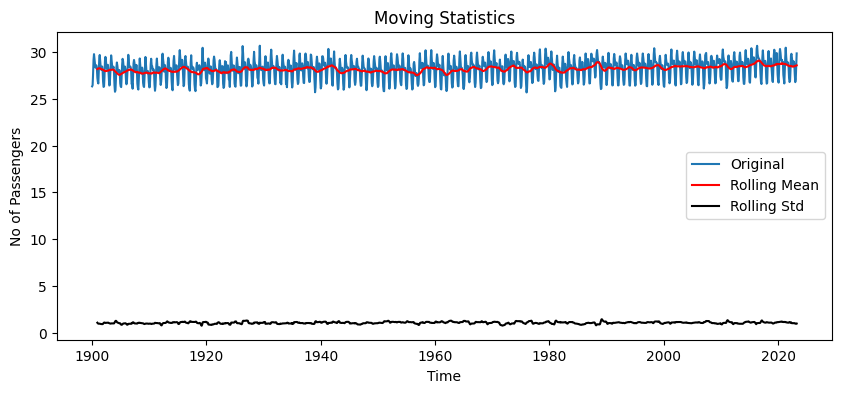

In [66]:
check_stationarity(data['Sea Surface Temperature (Deg C)'])

Results of Dickey-Fuller Test:
Test Statistic                -1.076241e+01
p-value                        2.501319e-19
#Lags Used                     2.400000e+01
Number of Observations Used    1.454000e+03
Critical Value (1%)           -3.434855e+00
Critical Value (5%)           -2.863530e+00
Critical Value (10%)          -2.567829e+00
dtype: float64
Reject the null hypothesis. The data is stationary.
------------------------------------------------------------


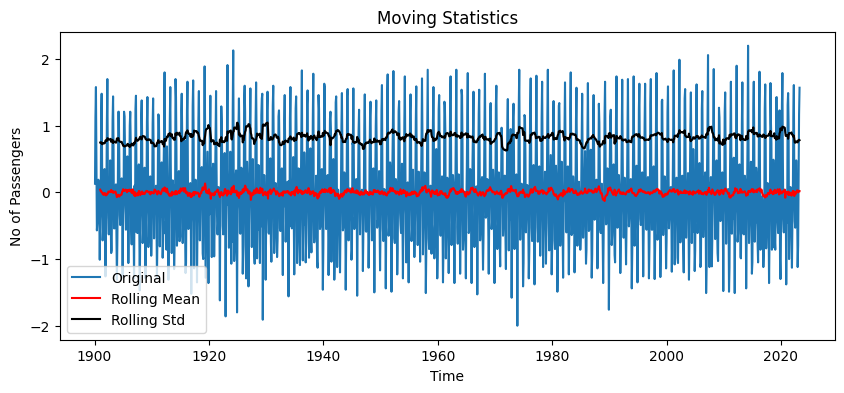

In [67]:
check_stationarity(data['Sea Surface Temperature (Deg C)'].diff())

Results of Dickey-Fuller Test:
Test Statistic                -1.682004e+01
p-value                        1.180290e-29
#Lags Used                     2.400000e+01
Number of Observations Used    1.453000e+03
Critical Value (1%)           -3.434859e+00
Critical Value (5%)           -2.863531e+00
Critical Value (10%)          -2.567830e+00
dtype: float64
Reject the null hypothesis. The data is stationary.
------------------------------------------------------------


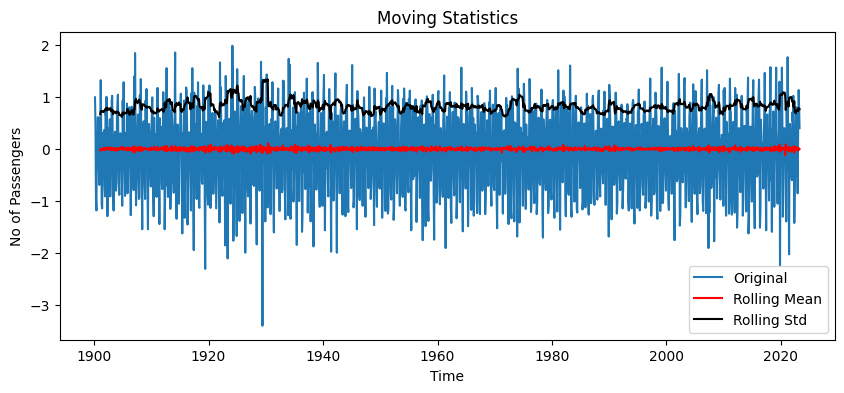

In [69]:
check_stationarity(data['Sea Surface Temperature (Deg C)'].diff().diff())

# Decomposing into seasonal components

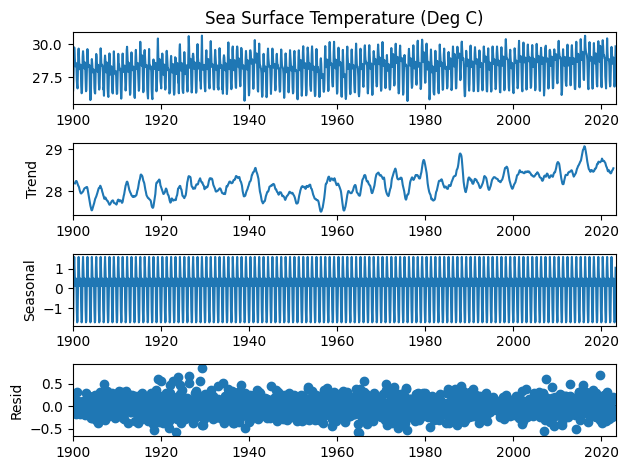

In [31]:
decomposition = sm.tsa.seasonal_decompose(data['Sea Surface Temperature (Deg C)'],
                                          period = 12,
                                          model = 'additive').plot()
plt.show()

<Axes: xlabel='Date'>

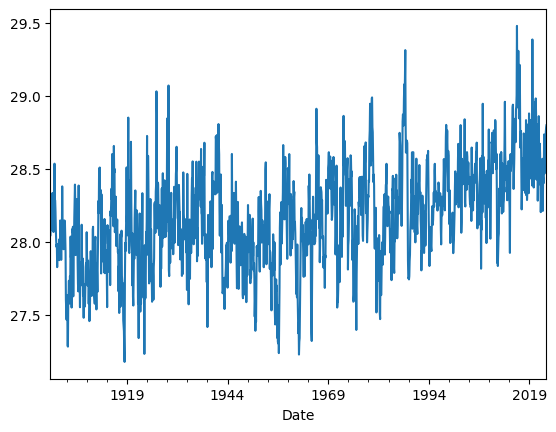

In [76]:
without_seasonal = data['Sea Surface Temperature (Deg C)'] - decomposition.seasonal
without_seasonal.plot()

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data['Sea Surface Temperature (Deg C)'], model='additive', period=12)


<Axes: xlabel='Date'>

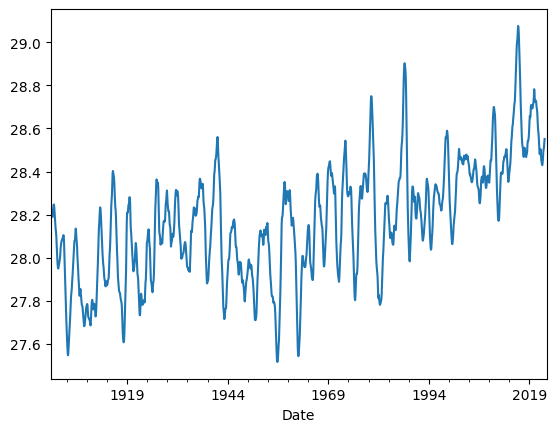

In [46]:
decomposition.trend.plot()

<Axes: xlabel='Date'>

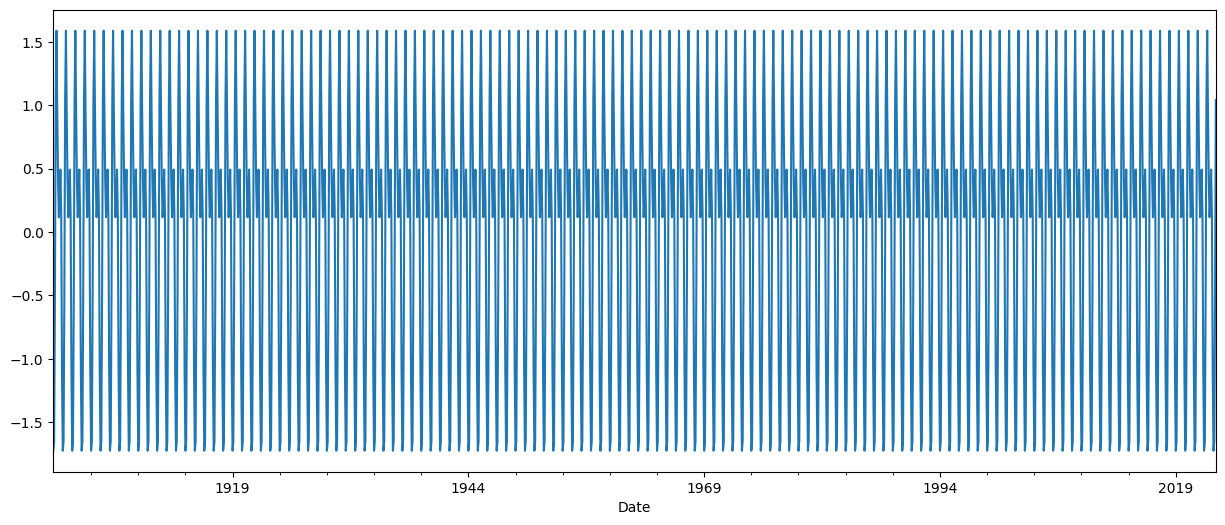

In [47]:
# Seasonal
decomposition.seasonal.plot(figsize=(15,6))

<Axes: xlabel='Date'>

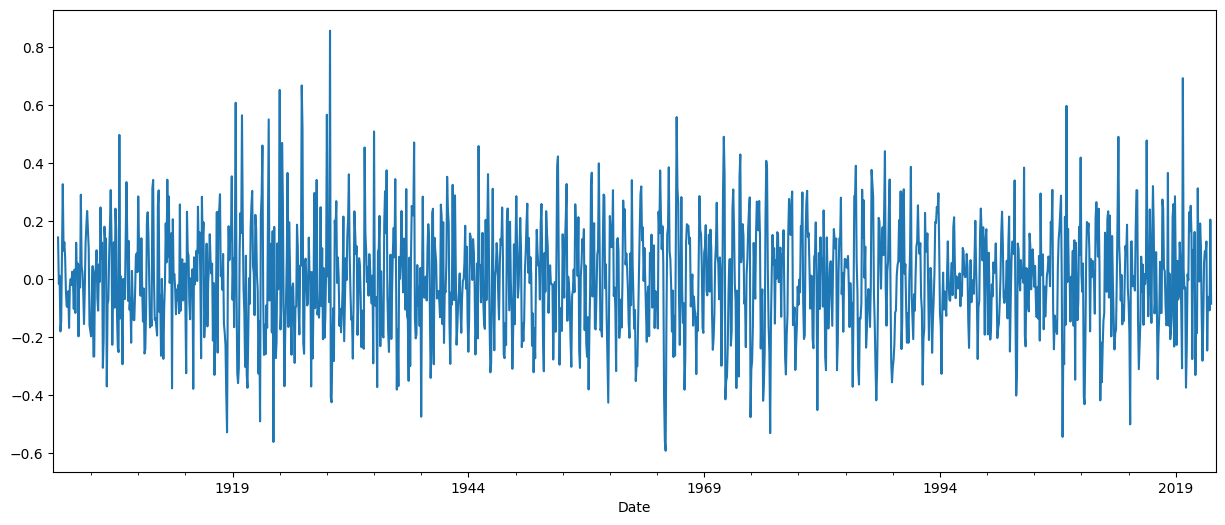

In [48]:
# Residual
decomposition.resid.plot(figsize=(15,6))

# Time series analysis Plots

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    y.dropna(inplace = True)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=(10,4))
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\nDickey-Fuller: p={0:.5f}'.format(p_value))
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()


# Plotting autocorrelation and Partial autocorrelation plots

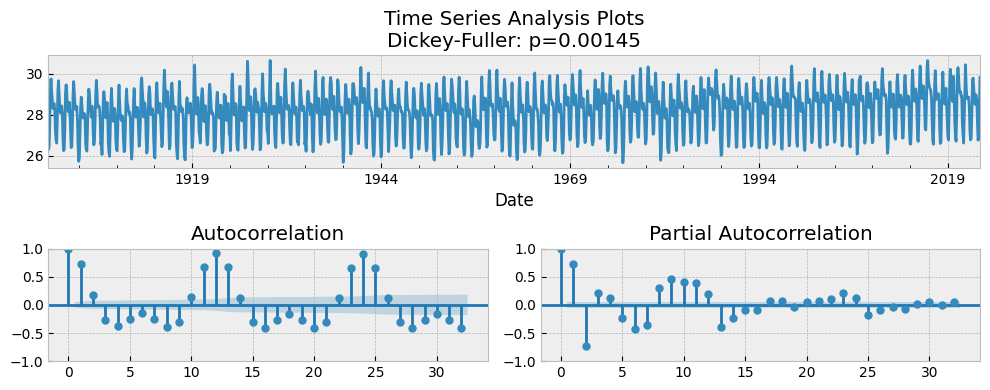

In [60]:
tsplot(data['Sea Surface Temperature (Deg C)'])

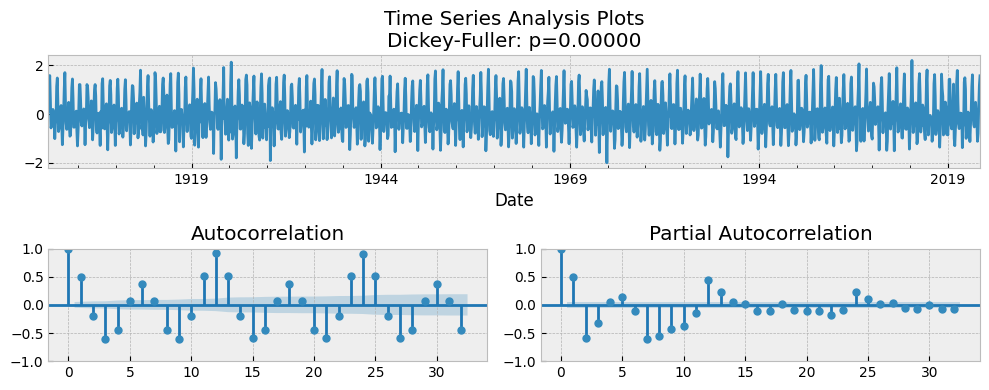

In [62]:
tsplot(data['Sea Surface Temperature (Deg C)'].diff())

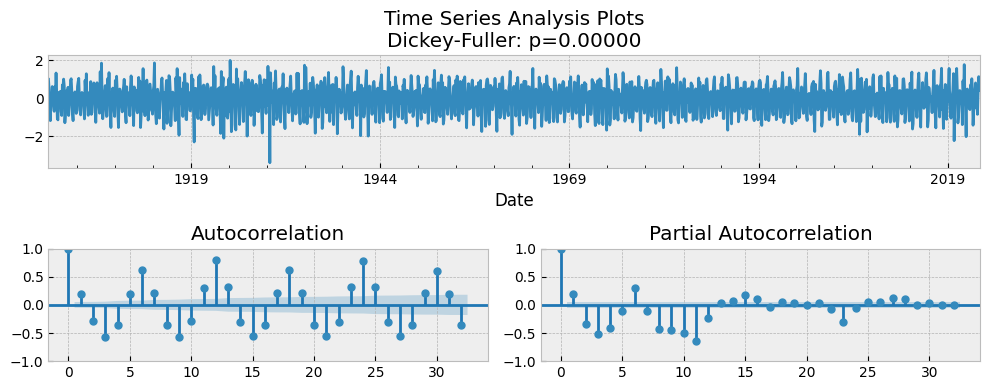

In [63]:
tsplot(data['Sea Surface Temperature (Deg C)'].diff().diff())

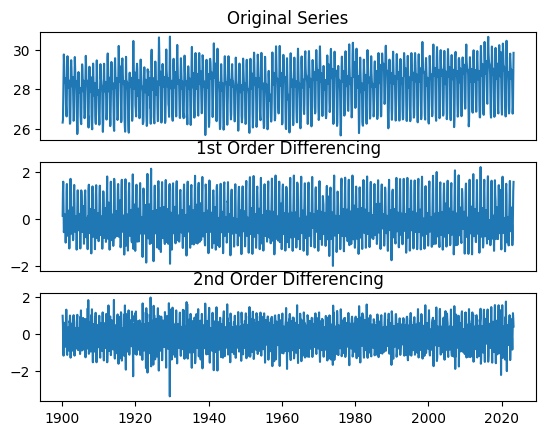

In [59]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(data['Sea Surface Temperature (Deg C)']); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(data['Sea Surface Temperature (Deg C)'].diff());
ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(data['Sea Surface Temperature (Deg C)'].diff().diff());
ax3.set_title('2nd Order Differencing')
plt.show()

**ARIMA**

---



# Finding the value of d parameter

**Since the dataset is already Stationary there is no need to difference the data. So, we set the value of d as 0.**

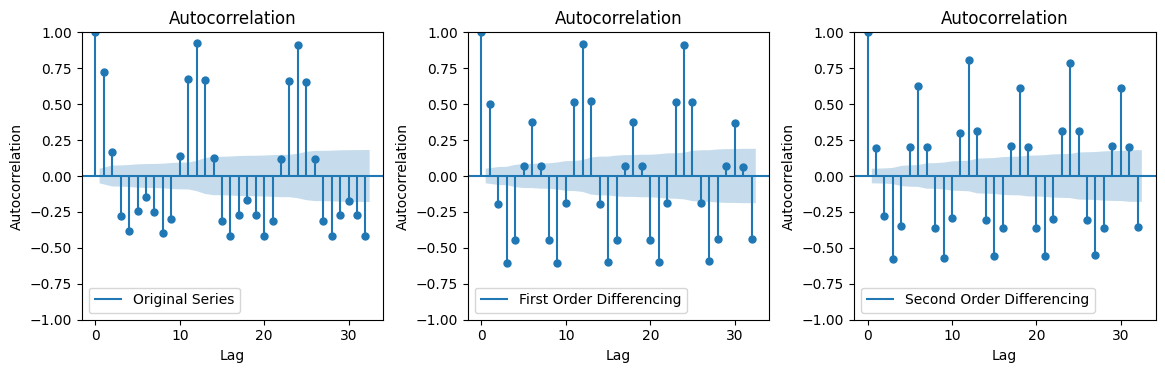

In [70]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
fig.tight_layout(pad=3.0)

# Plot 1
axs[0].set_title('Autocorrelation (Original Series)')
plot_acf(data['Sea Surface Temperature (Deg C)'], ax=axs[0])
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Autocorrelation')
axs[0].legend(['Original Series'])

# Plot 2
axs[1].set_title('Autocorrelation (First Order Differencing)')
plot_acf(data['Sea Surface Temperature (Deg C)'].diff().dropna(), ax=axs[1])
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Autocorrelation')
axs[1].legend(['First Order Differencing'])

# Plot 3
axs[2].set_title('Autocorrelation (Second Order Differencing)')
plot_acf(data['Sea Surface Temperature (Deg C)'].diff().diff().dropna(), ax=axs[2])
axs[2].set_xlabel('Lag')
axs[2].set_ylabel('Autocorrelation')
axs[2].legend(['Second Order Differencing'])

plt.show()


# Finding the value of p parameter

**Since the starting 3 lags are significantly out of the threshold region we set the value of p parameter as 3.**

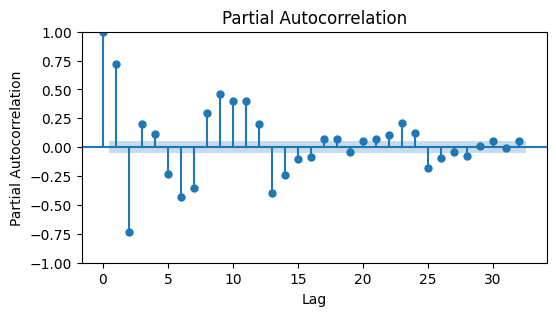

In [73]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(6, 3))

plot_pacf(data['Sea Surface Temperature (Deg C)'].dropna(), ax=ax)
ax.set_title('Partial Autocorrelation')
ax.set_xlabel('Lag')
ax.set_ylabel('Partial Autocorrelation')

plt.show()


# Finding the value of q

**Between the firsr 12 lags, 5 lags are significantly out of the threshold level. Hence we set the value of the q paramater as 5.**

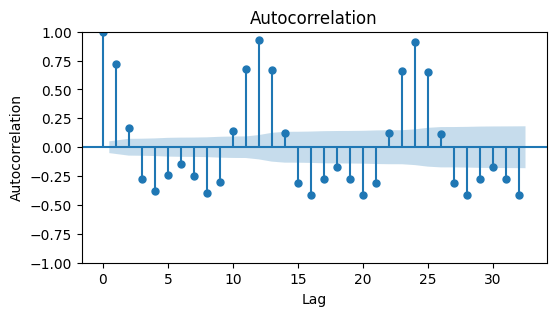

In [82]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(6, 3))

plot_acf(data['Sea Surface Temperature (Deg C)'].dropna(), ax=ax)
ax.set_title('Autocorrelation')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')

plt.show()

# Here we can see that 2 of the lags are out of the significance limit
# so we can say that the optimal value of our q (MA) is 2.

# Function to find out the optimal parameter for Arima and Sarima model

**From the above analysis we obtained the values of the parameters of the Arima model as p = 3, d = 0, q = 5.We shall further check with the help of the below function.**

In [81]:
# Time series is stationary

stepwise_model = auto_arima(data['Sea Surface Temperature (Deg C)'], stepwise=True, m=12, trace=True, stationary=True)
stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1188.016, Time=25.55 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4392.912, Time=0.19 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=11.23 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2176.717, Time=3.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=14085.253, Time=0.09 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=1471.475, Time=9.94 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=1199.952, Time=9.77 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=806.905, Time=27.21 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=1113.717, Time=25.21 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=951.239, Time=35.10 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=1120.138, Time=31.99 sec
 ARIMA(1,0,2)(2,0,1)[12] intercept   : AIC=778.884, Time=19.01 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=1083.221, Time=11.06 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=1032.911, Time=19.48 sec
 ARIMA(1,0,2)(2,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 1480
Model:             SARIMAX(3, 0, 5)x(2, 0, [1, 2], 12)   Log Likelihood                 -25.487
Date:                                 Sun, 30 Jul 2023   AIC                             78.975
Time:                                         10:59:53   BIC                            153.172
Sample:                                     01-01-1900   HQIC                           106.635
                                          - 04-01-2023                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.4619      1.394      3.917      0.000       2.729       8.195
ar.L1         -0.4575      0.087     -5.236      0.000      -0.629      -0.286
ar.L2         -0.8680      0.059    -14.831      0.000      -0.983      -0.753
ar.L3         -0.5236      0.088     -5.982      0.000      -0.695      -0.352
ma.L1          1.1301      0.084     13.494      0.000       0.966       1.294
ma.L2          1.5843      0.072     21.913      0.000       1.443       1.726
ma.L3          1.4274      0.098     14.634      0.000       1.236       1.619
ma.L4          0.7257      0.054     13.447      0.000       0.620       0.831
ma.L5          0.3390      0.027     12.555      0.000       0.286       0.392
ar.S.L12       0.1232      0.354      0.348      0.728      -0.571       0.817
ar.S.L24       0.8091      0.340      2.379      0.017       0.142       1.476
ma.S.L12       0.1921      0.350      0.549      0.583      -0.493       0.877
ma.S.L24      -0.5619      0.220     -2.549      0.011      -0.994      -0.130
sigma2         0.0572      0.002     29.302      0.000       0.053       0.061
===================================================================================
Ljung-Box (L1) (Q):                   2.11   Jarque-Bera (JB):                65.68
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**As we can see that the search above lead us the optimal values of the parameters for both the Arima and Sarima. p = 3, d = 0, q = 5, P = 2, D = 0, Q = 2, M = 12**

In [106]:
params = stepwise_model.get_params()
params

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (3, 0, 5),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 0, 2, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [105]:
train, test = data['Sea Surface Temperature (Deg C)'].iloc[:1200], data['Sea Surface Temperature (Deg C)'].iloc[1200:]

<Axes: xlabel='Date'>

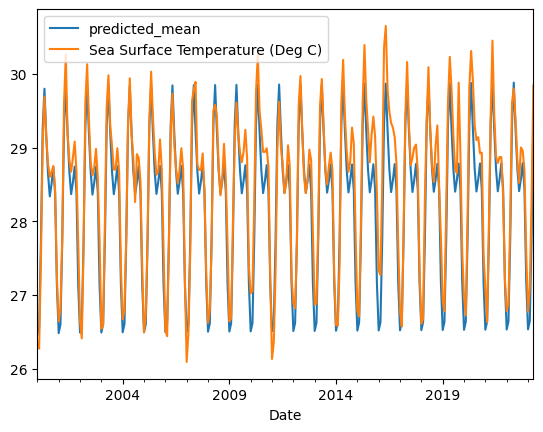

In [111]:
params = stepwise_model.get_params()
order = params['order']
seasonal_order = params['seasonal_order']

model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)

model_fit = model.fit()
start = len(train)
end = len(train) + len(test) - 1
prediction = model_fit.predict(start=start, end=end)
prediction.plot(legend=True)
test.plot(legend=True)

In [114]:
from math import sqrt
rmse = sqrt(mean_squared_error(test, prediction))
print(f"RMSE: {rmse}")
print(f"Series mean: {data['Sea Surface Temperature (Deg C)'].mean()}")

RMSE: 0.34369080966192217
Series mean: 28.168425675675678


# Arima Forecast

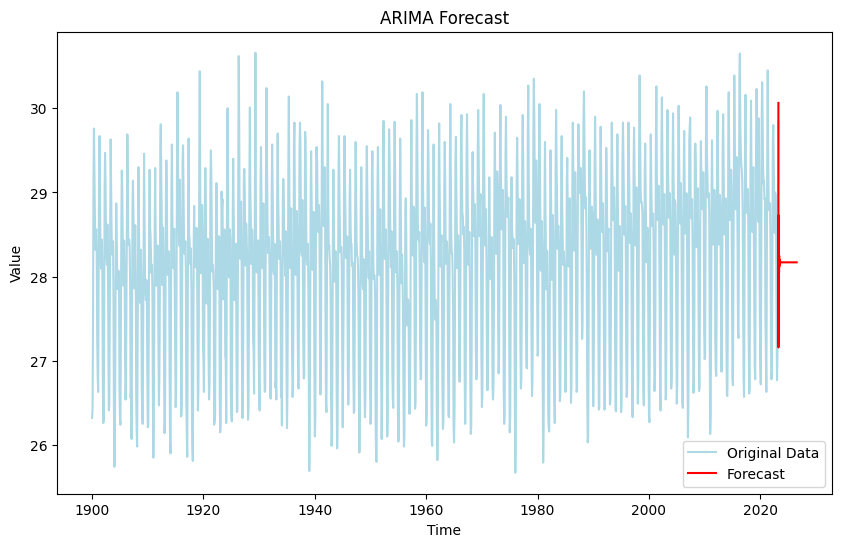

In [107]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

order = (3, 0, 5)
model = sm.tsa.ARIMA(data['Sea Surface Temperature (Deg C)'], order=order)
results = model.fit()

arima_params = results.params

steps = 1200
forecast_values = results.forecast(steps=steps)

future_index = pd.date_range(start=data['Sea Surface Temperature (Deg C)'].index[-1], periods=steps+1, freq=data['Sea Surface Temperature (Deg C)'].index.freq)

plt.figure(figsize=(10, 6))
plt.plot(data['Sea Surface Temperature (Deg C)'], label='Original Data', color='lightblue')
plt.plot(future_index[1:], forecast_values, label='Forecast', color='red')

plt.title('ARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


# Sarima Forecast

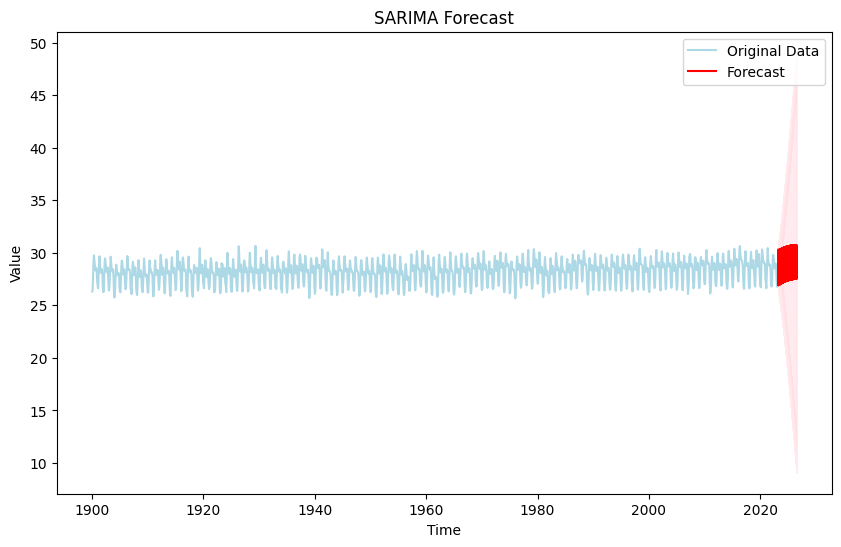

In [100]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

seasonal_order = (2, 0, 2, 12)
model = sm.tsa.SARIMAX(data['Sea Surface Temperature (Deg C)'], order=(3, 0, 5), seasonal_order=seasonal_order)
results = model.fit()

sarima_params = results.params

steps = 1200
forecast_values = results.get_forecast(steps=steps)

future_index = pd.date_range(start=data['Sea Surface Temperature (Deg C)'].index[-1], periods=steps, freq=data['Sea Surface Temperature (Deg C)'].index.freq)

plt.figure(figsize=(10, 6))
plt.plot(data['Sea Surface Temperature (Deg C)'], label='Original Data', color='lightblue')
plt.plot(future_index, forecast_values.predicted_mean, label='Forecast', color='red')

ci = forecast_values.conf_int(alpha=0.05)
plt.fill_between(future_index, ci.iloc[:, 0], ci.iloc[:, 1], color='pink', alpha=0.3)

plt.title('SARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


# Sarimax Forecast

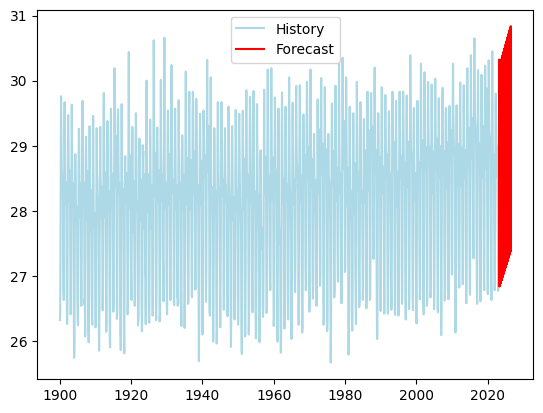

In [124]:
input_timestamps = 1200

forecast_model = SARIMAX(data['Sea Surface Temperature (Deg C)'], order=order,
                  seasonal_order=seasonal_order,
                  enforce_stationarity=False, enforce_invertibility=True)

forecast_fit = forecast_model.fit()

forecast = forecast_fit.predict(start=len(data['Sea Surface Temperature (Deg C)']), end=len(data['Sea Surface Temperature (Deg C)'])+input_timestamps)
forecast.index = pd.date_range(data['Sea Surface Temperature (Deg C)'].index[-1], periods= input_timestamps+1, freq=data['Sea Surface Temperature (Deg C)'].index.freq)
plt.plot(data['Sea Surface Temperature (Deg C)'].index, data['Sea Surface Temperature (Deg C)'], label='History', color = 'lightblue')
plt.plot(forecast.index, forecast, label='Forecast', color = 'red')
plt.legend(loc='best')